In [1]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from pathlib import Path
import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score, roc_curve
from collections import Counter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings 
warnings.filterwarnings('ignore')

### Data Exploration: Baseline Characteristics

In [2]:
label_path = 'D:/nodule/data/labels/'

label = [pd.DataFrame(pd.read_csv(os.path.join(label_path, file), delim_whitespace = True)) for file in os.listdir(label_path)]
df = pd.concat(label, ignore_index = True)
df['types'] = [string.split('/') for string in df['image']]
df['types'] = [string[0] for string in df['types']]
df['image'] = [string.split('/') for string in df['image']]
df['image'] = [string[1][6:-4] for string in df['image']]

dict = {}
image_path = 'D:/nodule/data/images/'
folders = os.listdir(image_path)
images = ([os.listdir(os.path.join(image_path, folder)) for folder in folders])
test_images  = images[0]
train_images = images[1]
valid_images = images[2]

In [90]:
class NoduleDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, image_path, transforms = None):    
        self.transform  = transforms
        self.data_path  = data_path
        self.images_dir = data_path / 'images' / Path(image_path)

        if   image_path == 'train': 
            self.labels_dir = data_path / 'labels' / 'trainlabels.txt'
        elif image_path == 'val':
            self.labels_dir = data_path / 'labels' / 'vallabels.txt'
        elif image_path == 'test' :
            self.labels_dir = data_path / 'labels' / 'testlabels.txt'
        self.dataset = self._load_data(self.images_dir, self.labels_dir)

    def __getitem__(self, index):
        dataset  = self.dataset
        img_path = self.images_dir / dataset[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = dataset[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset) 

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data
    
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize((50, 50)), 
        transforms.RandomCrop(32, padding = 2),         
        transforms.CenterCrop(40),         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.CenterCrop(40),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


data_path  = Path('D:/nodule/data/')
train_dataset  = NoduleDataset(data_path, image_path = 'train', transforms = train_transform)
valid_dataset  = NoduleDataset(data_path, image_path = 'val',   transforms = valid_transform)
test_dataset   = NoduleDataset(data_path, image_path = 'test',  transforms = valid_transform)

train_classes = [label for _, label in train_dataset]
class_count = Counter(train_classes)
class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
class_samples = [0] * len(class_weights)

for _, label in train_dataset:
    class_samples[label] += 1
weights = [class_weights[label] / class_samples[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)

torch.manual_seed(42)
train_loader   = DataLoader(train_dataset, batch_size = 32, sampler = sampler)
valid_loader   = DataLoader(valid_dataset, batch_size = 32, shuffle = True   )
test_loader    = DataLoader(test_dataset,  batch_size = 32, shuffle = False  )

Label: [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1]
Class:  M M M M B M M M M M M M M M M B M M M M M M M B B M M M M M B M


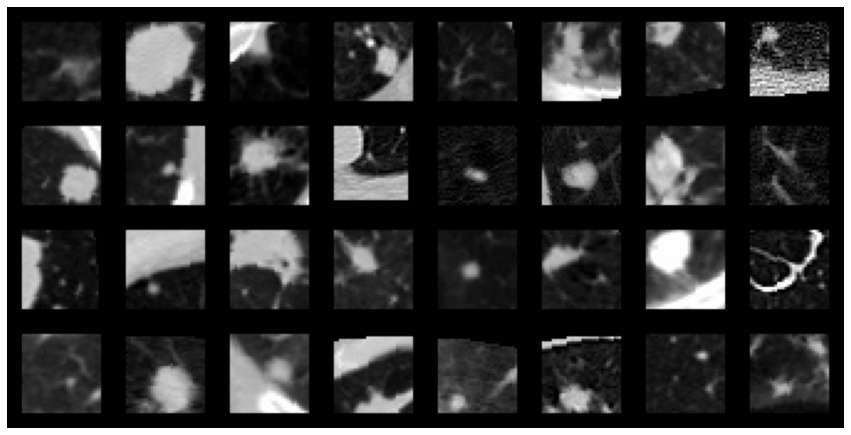

In [95]:
def display_images_from_loader(loader, class_names = ['B', 'M'], nrow = 8):
    for images, labels in loader:
        break

    print('Label:', labels.numpy())
    print('Class: ', *np.array([class_names[i] for i in labels]))

    im = make_grid(images, nrow=nrow)
    plt.figure(figsize=(15, 8))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()
display_images_from_loader(train_loader)

In [59]:
class NoduleDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir        
        self.transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.RandomCrop(32, padding = 2),
            transforms.RandomRotation(90),
            transforms.CenterCrop(40),
            transforms.ToTensor(), 
            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std  = [0.229, 0.224, 0.225])])
        
        self.images_dir = data_dir / 'images'
        self.labels_dir = data_dir / 'labels'

        self.train_images_dir = self.images_dir 
        self.val_images_dir   = self.images_dir  
        self.test_images_dir  = self.images_dir  

        self.train_labels_file = self.labels_dir  / 'trainlabels.txt'
        self.val_labels_file   = self.labels_dir  / 'vallabels.txt'
        self.test_labels_file  = self.labels_dir  / 'testlabels.txt'

        self.train_data = self._load_data(self.train_images_dir, self.train_labels_file)
        self.val_data   = self._load_data(self.val_images_dir, self.val_labels_file)
        self.test_data  = self._load_data(self.test_images_dir, self.test_labels_file)

    def __getitem__(self, index):
        if index < len(self.train_data):
            images_dir = self.train_images_dir
            data = self.train_data
        elif index < len(self.train_data) + len(self.val_data):
            images_dir = self.val_images_dir
            data = self.val_data
            index -= len(self.train_data)
        else:
            images_dir = self.test_images_dir
            data = self.test_data
            index -= (len(self.train_data) + len(self.val_data))

        img_path = images_dir / data[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = data[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.train_data) + len(self.val_data) + len(self.test_data)

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = filename 
            label = int(label)
            data.append((filename, label))
        return data

    def get_datasets(self):
        train_dataset = Subset(self, range(len(self.train_data)))
        test_dataset  = Subset(self, range(len(self.train_data),  len(self.train_data) + len(self.test_data)))
        valid_dataset = Subset(self, range(len(self.train_data) + len(self.test_data),   len(self)))
        return train_dataset, test_dataset, valid_dataset

def GET_NODULEDATASET():
    train_indices = list(range(0, len(dataset.train_data)))
    valid_indices = list(range(len(dataset.train_data),  len(dataset.train_data) + len(dataset.val_data)))
    test_indices  = list(range(len(dataset.train_data) + len(dataset.val_data), len(dataset)))

    train_dataset = Subset(dataset, train_indices)
    valid_dataset = Subset(dataset, valid_indices)
    test_dataset  = Subset(dataset, test_indices)
    return train_dataset, valid_dataset, test_dataset

data_dir = Path('D:/nodule/data/')
dataset  = NoduleDataset(data_dir)
train_dataset, valid_dataset, test_dataset = GET_NODULEDATASET()

train_classes = [label for _, label in train_dataset]
class_count = Counter(train_classes)
class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
class_samples = [0] * len(class_weights)

for _, label in train_dataset:
    class_samples[label] += 1
weights = [class_weights[label] / class_samples[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)

train_loader  = DataLoader(train_dataset, batch_size = 32, sampler = sampler)
valid_loader  = DataLoader(valid_dataset, batch_size = 32, shuffle = True )
test_loader   = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

In [83]:
import warnings 
warnings.filterwarnings('ignore')

import torch.nn.functional as F

class EarlyStopping:
  def __init__(self, patience  = 1, delta = 0, path = 'checkpoint.pt'):
    self.patience = patience
    self.delta = delta
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct       = (rounded_preds == y).float()
    acc           = correct.sum() / len(correct)
    return acc

def get_metrics(prediction, label):
    prediction  = prediction.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    
    tp = np.sum((prediction == 1) & (label == 1))
    tn = np.sum((prediction == 0) & (label == 0))
    fp = np.sum((prediction == 1) & (label == 0))
    fn = np.sum((prediction == 0) & (label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    try:
        auc = roc_auc_score(label, prediction)
    except ValueError:
        auc = None
    fpr, tpr, _ = roc_curve(label, prediction)

    return {'sensitivity': sensitivity,
            'specificity': specificity,
            'auc': auc,
            'fpr': fpr,
            'tpr': tpr}

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    train_metric, valid_metric = [], []

    epoch_times = []
    list_best_epochs = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_accu, train_metr = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, valid_metr = _evals(model, valid_loader, criterion, device)

        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
           print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        train_metric.append(train_metr)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        valid_metric.append(valid_metr)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_metr  = _evals(best_model, test_loader, criterion, device)
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times

def _train(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_train_loss = 0
    epoch_train_accu = 0

    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)[:, 0]
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        accuracy = binary_accuracy(outputs, labels)
        metric  = get_metrics(outputs, labels)
        epoch_train_accu += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader) 
    epoch_train_accu = epoch_train_accu / len(train_loader) 
    return epoch_train_loss, epoch_train_accu, metric

def _evals(model, valid_loader, criterion, device):
    model.eval()
    epoch_valid_loss = 0
    epoch_valid_accu = 0

    all_predictions = []

    with torch.no_grad():
        for id, data in enumerate(valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)[:, 0]
            loss = criterion(outputs, labels.float())
            rounded_preds = torch.round(torch.sigmoid(outputs)).long().flatten().tolist()
            all_predictions.extend(rounded_preds)

            epoch_valid_loss += loss.item()
            accuracy = binary_accuracy(outputs, labels)
            metric  = get_metrics(outputs, labels)
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accu = epoch_valid_accu / len(valid_loader)
    return epoch_valid_loss, epoch_valid_accu, metric

In [153]:
torch.manual_seed(42)
model_vgg19 = torchvision.models.vgg19(weights = True).to(device)
model_vgg19.classifier[-1] = torch.nn.Linear(4096, 2)
model_vgg19.classifier.add_module('logsoftmax', nn.LogSoftmax(dim = 1))

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg19.parameters(), lr = 0.01, eps = 10e-06)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(2, model_vgg19, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.69466   	 Accuracy: 0.0 	 Validation Loss  0.69315 	 Accuracy: 0.0
Epoch: 2 	 Training: Loss 0.69315   	 Accuracy: 0.0 	 Validation Loss  0.69315 	 Accuracy: 0.0
Final Best Model from Best Epoch 1 Test Loss = 0.6931471801271626, Test Accuracy = 0.0


In [7]:
torch.manual_seed(42)
model_vgg19 = torchvision.models.vgg19(weights = True).to(device)
model_vgg19.classifier[-1] = torch.nn.Linear(4096, 2)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg19.parameters(), lr = 1e-2, eps = 10e-06)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(2, model_vgg19, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 15.7254   	 Accuracy: 0.83666 	 Validation Loss  82.79232 	 Accuracy: 0.17208
Epoch: 2 	 Training: Loss 16.21933   	 Accuracy: 0.83781 	 Validation Loss  82.72507 	 Accuracy: 0.17275
Final Best Model from Best Epoch 1 Test Loss = 82.66488408107384, Test Acc = 0.17335115869839987


In [105]:
model_alexnet = models.alexnet(pretrained = True)

model_alexnet.features[0] = torch.nn.Conv2d(3,  64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[2] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
model_alexnet.features[3] = torch.nn.Conv2d(64, 192, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[5] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

model_alexnet.classifier[6] = torch.nn.Linear(4096, 2)
model_alexnet.classifier[6].requires_grad = True

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_alexnet.classifier.parameters(), lr = 0.001, eps = 10e-06)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(2, model_alexnet, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 16.83681   	 Accuracy: 0.82554                                   	 Validation Loss  82.79232 	 Accuracy: 0.17208
Epoch: 2 	 Training: Loss 16.27045   	 Accuracy: 0.8373                                   	 Validation Loss  82.79232 	 Accuracy: 0.17208
Final Best Model from Best Epoch 0 Test Loss = 82.66488408107384, Test Acc = 0.17335115869839987


In [139]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

        self.dropout = nn.Dropout(p = 0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = nn.functional.sigmoid(x)
        return x


torch.manual_seed(101)
model_cnn = LeNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.1)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(2, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.48521   	 Accuracy: 0.0 	 Validation Loss  1.13984 	 Accuracy: 0.0
Epoch: 2 	 Training: Loss 0.4807   	 Accuracy: 0.0 	 Validation Loss  1.14051 	 Accuracy: 0.0
Final Best Model from Best Epoch 1 Test Loss = 1.13991066755033, Test Accuracy = 0.0


In [167]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 5),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),

            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),

            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),

            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.classifier1 = nn.Linear(256, num_classes)
        self.classifier2 = nn.Linear(2, num_classes)
        self.classifier3 = nn.Linear(2, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier1(x)
        x = self.classifier2(x)
        x = self.classifier3(x)
        return x

torch.manual_seed(101)
model_cnn = AlexNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.1)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(20, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 82.80669   	 Accuracy: 0.16584 	 Validation Loss  17.07317 	 Accuracy: 0.82927
Epoch: 2 	 Training: Loss 83.10966   	 Accuracy: 0.1689 	 Validation Loss  17.34218 	 Accuracy: 0.82658
Epoch: 3 	 Training: Loss 83.52505   	 Accuracy: 0.16475 	 Validation Loss  17.14042 	 Accuracy: 0.8286
Epoch: 4 	 Training: Loss 83.05215   	 Accuracy: 0.16948 	 Validation Loss  17.14042 	 Accuracy: 0.8286
Epoch: 5 	 Training: Loss 83.78067   	 Accuracy: 0.16219 	 Validation Loss  17.27493 	 Accuracy: 0.82725
Epoch: 6 	 Training: Loss 83.93405   	 Accuracy: 0.16066 	 Validation Loss  17.40943 	 Accuracy: 0.82591
Epoch: 7 	 Training: Loss 83.28221   	 Accuracy: 0.16718 	 Validation Loss  17.40943 	 Accuracy: 0.82591
Epoch: 8 	 Training: Loss 82.7454   	 Accuracy: 0.17255 	 Validation Loss  17.34218 	 Accuracy: 0.82658
Epoch: 9 	 Training: Loss 83.32694   	 Accuracy: 0.16673 	 Validation Loss  17.27493 	 Accuracy: 0.82725
Epoch: 10 	 Training: Loss 84.60506   	 Accuracy: 0.15395 	

In [39]:
class SamuelNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(SamuelNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 5),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),

            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),

            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),

            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.classifier1 = nn.Linear(256, num_classes)
        self.classifier2 = nn.Linear(2, num_classes)
        self.classifier3 = nn.Linear(2, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier1(x)
        x = self.classifier2(x)
        x = self.classifier3(x)
        return x

torch.manual_seed(101)
model_cnn = SamuelNet()
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model_cnn.parameters(), lr = 0.1)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.16315   	 Accuracy: 0.83075 	 Validation Loss  1.70732 	 Accuracy: 0.82927
Epoch: 2 	 Training: Loss 0.1689   	 Accuracy: 0.8311 	 Validation Loss  1.73422 	 Accuracy: 0.82658
Epoch: 3 	 Training: Loss 0.16475   	 Accuracy: 0.83525 	 Validation Loss  1.71404 	 Accuracy: 0.8286
Epoch: 4 	 Training: Loss 0.16948   	 Accuracy: 0.83052 	 Validation Loss  1.71404 	 Accuracy: 0.8286
Epoch: 5 	 Training: Loss 0.16219   	 Accuracy: 0.83781 	 Validation Loss  1.72749 	 Accuracy: 0.82725
Epoch: 6 	 Training: Loss 0.16066   	 Accuracy: 0.83934 	 Validation Loss  1.74094 	 Accuracy: 0.82591
Epoch: 7 	 Training: Loss 0.16718   	 Accuracy: 0.83282 	 Validation Loss  1.74094 	 Accuracy: 0.82591
Epoch: 8 	 Training: Loss 0.17255   	 Accuracy: 0.82745 	 Validation Loss  1.73422 	 Accuracy: 0.82658
Epoch: 9 	 Training: Loss 0.16673   	 Accuracy: 0.83327 	 Validation Loss  1.72749 	 Accuracy: 0.82725
Epoch: 10 	 Training: Loss 0.15395   	 Accuracy: 0.84605 	 Validation Loss  1

In [63]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 11, stride = 4, padding = 5),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size = 3, stride = 2),

            nn.Conv2d(32, 256, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(256, 32, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 8, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.5, inplace = True)
        self.classifier1 = nn.Linear(8, 8)
        self.classifier2 = nn.Linear(8, 4)
        self.classifier3 = nn.Linear(4, num_classes)
        self.classifier4 = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.classifier1(x))
        x = self.relu(self.classifier2(x))
        x = self.classifier3(x)
        return x

torch.manual_seed(101)
model_cnn = AlexNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.0001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.59994   	 Accuracy: 0.8288 	 Validation Loss  0.63598 	 Accuracy: 0.82725
Epoch: 2 	 Training: Loss 0.5582   	 Accuracy: 0.84209 	 Validation Loss  0.64121 	 Accuracy: 0.82658
Epoch: 3 	 Training: Loss 0.52862   	 Accuracy: 0.83052 	 Validation Loss  0.65187 	 Accuracy: 0.78381
Epoch: 4 	 Training: Loss 0.49307   	 Accuracy: 0.83333 	 Validation Loss  0.65411 	 Accuracy: 0.76466
Epoch: 5 	 Training: Loss 0.46103   	 Accuracy: 0.83531 	 Validation Loss  0.64935 	 Accuracy: 0.78609
Epoch: 6 	 Training: Loss 0.44167   	 Accuracy: 0.82733 	 Validation Loss  0.67351 	 Accuracy: 0.66898
Epoch: 7 	 Training: Loss 0.40419   	 Accuracy: 0.83442 	 Validation Loss  0.67353 	 Accuracy: 0.64096
Epoch: 8 	 Training: Loss 0.39412   	 Accuracy: 0.83768 	 Validation Loss  0.66913 	 Accuracy: 0.66051
Epoch: 9 	 Training: Loss 0.38287   	 Accuracy: 0.83442 	 Validation Loss  0.67979 	 Accuracy: 0.62428
Epoch: 10 	 Training: Loss 0.37337   	 Accuracy: 0.83915 	 Validation Loss 

In [67]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32,   2)

        self.dropout = nn.Dropout(p = 0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


torch.manual_seed(101)
model_cnn = LeNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(10, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.47196   	 Accuracy: 0.83992 	 Validation Loss  1.19423 	 Accuracy: 0.17409
Epoch: 2 	 Training: Loss 0.46504   	 Accuracy: 0.83646 	 Validation Loss  0.92657 	 Accuracy: 0.17275
Epoch: 3 	 Training: Loss 0.46407   	 Accuracy: 0.83289 	 Validation Loss  0.72725 	 Accuracy: 0.26049
Epoch: 4 	 Training: Loss 0.44666   	 Accuracy: 0.84011 	 Validation Loss  0.68376 	 Accuracy: 0.51175
Epoch: 5 	 Training: Loss 0.44792   	 Accuracy: 0.83736 	 Validation Loss  0.72203 	 Accuracy: 0.41324
Epoch: 6 	 Training: Loss 0.43253   	 Accuracy: 0.83877 	 Validation Loss  0.60734 	 Accuracy: 0.71359
Epoch: 7 	 Training: Loss 0.44568   	 Accuracy: 0.82656 	 Validation Loss  0.72533 	 Accuracy: 0.34339
Epoch: 8 	 Training: Loss 0.4385   	 Accuracy: 0.83825 	 Validation Loss  0.67933 	 Accuracy: 0.56914
Epoch: 9 	 Training: Loss 0.42681   	 Accuracy: 0.83468 	 Validation Loss  0.64987 	 Accuracy: 0.6905
Epoch: 10 	 Training: Loss 0.42705   	 Accuracy: 0.83289 	 Validation Loss 

In [71]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32,   2)

        self.dropout = nn.Dropout(p = 0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


torch.manual_seed(101)
model_cnn = LeNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times = train(50, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.47196   	 Accuracy: 0.83992 	 Validation Loss  1.19423 	 Accuracy: 0.17409
Epoch: 2 	 Training: Loss 0.46504   	 Accuracy: 0.83646 	 Validation Loss  0.92657 	 Accuracy: 0.17275
Epoch: 3 	 Training: Loss 0.46407   	 Accuracy: 0.83289 	 Validation Loss  0.72725 	 Accuracy: 0.26049
Epoch: 4 	 Training: Loss 0.44666   	 Accuracy: 0.84011 	 Validation Loss  0.68376 	 Accuracy: 0.51175
Epoch: 5 	 Training: Loss 0.44792   	 Accuracy: 0.83736 	 Validation Loss  0.72203 	 Accuracy: 0.41324
Epoch: 6 	 Training: Loss 0.43253   	 Accuracy: 0.83877 	 Validation Loss  0.60734 	 Accuracy: 0.71359
Epoch: 7 	 Training: Loss 0.44568   	 Accuracy: 0.82656 	 Validation Loss  0.72533 	 Accuracy: 0.34339
Epoch: 8 	 Training: Loss 0.4385   	 Accuracy: 0.83825 	 Validation Loss  0.67933 	 Accuracy: 0.56914
Epoch: 9 	 Training: Loss 0.42681   	 Accuracy: 0.83468 	 Validation Loss  0.64987 	 Accuracy: 0.6905
Epoch: 10 	 Training: Loss 0.42705   	 Accuracy: 0.83289 	 Validation Loss 